# Experiment with an XGBoost Regression on basic weather data by Street

Updated to use the full Foot Traffic Weather data from 2013 - July 2022

This will use XGBoost Regression as the model. It will use 5x K-Folds Cross Validation to train then fit the model and evaluate the MAE and RMSE. For each fold, it will write out the data with the predictions to the /predictions folder so we can look at what the model is predicting vs the true people count.

Also, This version has been updated so that it will use the FT_Street_Melb versions of files that have the counts by selected street locations. Will need to One hot encode the street before predicting

In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb

from utilities import data_basic_utility as databasic
from utilities import dataframe_utility as dfutil
from utilities import statistics_utility as stats

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

# dfFootWeather = pd.read_csv("./data_files/FootTrafficWeather_July2022_Melbourne.csv")
dfFootWeather = pd.read_csv("./data_files/FT_Street_Melb_20130101_20220701.csv", parse_dates=["date"])
thisFileName = "11a.StreetXGboostV1"

print(dfFootWeather.shape)
print(dfFootWeather.info())
dfFootWeather.head()

(24633, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24633 entries, 0 to 24632
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        24633 non-null  datetime64[ns]
 1   street                                      24633 non-null  object        
 2   total_people                                24633 non-null  int64         
 3   total_rain                                  23534 non-null  float64       
 4   rain_quality                                23534 non-null  object        
 5   max_temp                                    23569 non-null  float64       
 6   max_temp_quality                            23562 non-null  object        
 7   min_temp                                    23562 non-null  float64       
 8   min_temp_quality                            23562 non-null  object        

,date,street,total_people,total_rain,rain_quality,max_temp,max_temp_quality,min_temp,min_temp_quality,solar_exp,...,population_annual,population_change_annual,is_holiday,is_lockdown,OfflineRetail_Original_Turnover,OfflineRetail_Seasonally_Adjusted_Turnover,OfflineRetail_Trend_Turnover,all_ords,sp_asx200,dom_equity_market_cap
0,2022-07-31,Bourke Street Mall (North),15434,0.0,N,14.7,Y,4.3,Y,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0
1,2022-07-31,Spencer St-Collins St (North),12349,0.0,N,14.7,Y,4.3,Y,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0
2,2022-07-31,Southern Cross Station,1661,0.0,N,14.7,Y,4.3,Y,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0
3,2022-07-31,QV Market-Peel St,3203,0.0,N,14.7,Y,4.3,Y,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0
4,2022-07-31,Melbourne Central,23363,0.0,N,14.7,Y,4.3,Y,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0


In [14]:
dfFootWeather = dfFootWeather[dfFootWeather["total_rain"].notna()]
dfFootWeather = dfFootWeather[dfFootWeather["solar_exp"].notna()]

# assume missing quality is an N
dfFootWeather.loc[dfFootWeather["max_temp_quality"].isna(), "max_temp_quality"] = "N"

print(dfFootWeather.shape)
print(dfFootWeather.info())
dfFootWeather.head()

(23527, 21)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23527 entries, 0 to 23568
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        23527 non-null  datetime64[ns]
 1   street                                      23527 non-null  object        
 2   total_people                                23527 non-null  int64         
 3   total_rain                                  23527 non-null  float64       
 4   rain_quality                                23527 non-null  object        
 5   max_temp                                    23527 non-null  float64       
 6   max_temp_quality                            23527 non-null  object        
 7   min_temp                                    23527 non-null  float64       
 8   min_temp_quality                            23527 non-null  object        

,date,street,total_people,total_rain,rain_quality,max_temp,max_temp_quality,min_temp,min_temp_quality,solar_exp,...,population_annual,population_change_annual,is_holiday,is_lockdown,OfflineRetail_Original_Turnover,OfflineRetail_Seasonally_Adjusted_Turnover,OfflineRetail_Trend_Turnover,all_ords,sp_asx200,dom_equity_market_cap
0,2022-07-31,Bourke Street Mall (North),15434,0.0,N,14.7,Y,4.3,Y,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0
1,2022-07-31,Spencer St-Collins St (North),12349,0.0,N,14.7,Y,4.3,Y,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0
2,2022-07-31,Southern Cross Station,1661,0.0,N,14.7,Y,4.3,Y,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0
3,2022-07-31,QV Market-Peel St,3203,0.0,N,14.7,Y,4.3,Y,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0
4,2022-07-31,Melbourne Central,23363,0.0,N,14.7,Y,4.3,Y,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0


### Feature Engineering

First, we need to convert any non-number columns into numbers that the model can understand. This first version isn't doing anything beyond that, later on we should probably look for any missing data flags, and maybe do some column Min/Max scaling or other.

Convert the 3 Quality Y/N columns into 1/0 values, use the shared utility function for future code reuse

In [15]:
dfFootWeather = dfutil.convertBoolColToInt(dfFootWeather, "rain_quality")
dfFootWeather = dfutil.convertBoolColToInt(dfFootWeather, "max_temp_quality")
dfFootWeather = dfutil.convertBoolColToInt(dfFootWeather, "min_temp_quality")
dfFootWeather.head()

,date,street,total_people,total_rain,rain_quality,max_temp,max_temp_quality,min_temp,min_temp_quality,solar_exp,...,population_annual,population_change_annual,is_holiday,is_lockdown,OfflineRetail_Original_Turnover,OfflineRetail_Seasonally_Adjusted_Turnover,OfflineRetail_Trend_Turnover,all_ords,sp_asx200,dom_equity_market_cap
0,2022-07-31,Bourke Street Mall (North),15434,0.0,0,14.7,1,4.3,1,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0
1,2022-07-31,Spencer St-Collins St (North),12349,0.0,0,14.7,1,4.3,1,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0
2,2022-07-31,Southern Cross Station,1661,0.0,0,14.7,1,4.3,1,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0
3,2022-07-31,QV Market-Peel St,3203,0.0,0,14.7,1,4.3,1,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0
4,2022-07-31,Melbourne Central,23363,0.0,0,14.7,1,4.3,1,4.8,...,5151000,1.78,NaN,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0


In [16]:
print(type(dfFootWeather["date"].dtype))
print(dfFootWeather["date"].dtype == "object")
print(dfFootWeather["date"][0])

<class 'numpy.dtype[datetime64]'>
False
2022-07-31 00:00:00


In [17]:
dfFootWeather = dfutil.separateYmdCol(dfFootWeather, "date")
print(dfFootWeather.info())
dfFootWeather.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23527 entries, 0 to 23568
Data columns (total 23 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   street                                      23527 non-null  object 
 1   total_people                                23527 non-null  int64  
 2   total_rain                                  23527 non-null  float64
 3   rain_quality                                23527 non-null  int64  
 4   max_temp                                    23527 non-null  float64
 5   max_temp_quality                            23527 non-null  int64  
 6   min_temp                                    23527 non-null  float64
 7   min_temp_quality                            23527 non-null  int64  
 8   solar_exp                                   23527 non-null  float64
 9   WeekDay                                     23527 non-null  int64  
 10  population

,street,total_people,total_rain,rain_quality,max_temp,max_temp_quality,min_temp,min_temp_quality,solar_exp,WeekDay,...,is_lockdown,OfflineRetail_Original_Turnover,OfflineRetail_Seasonally_Adjusted_Turnover,OfflineRetail_Trend_Turnover,all_ords,sp_asx200,dom_equity_market_cap,date_year,date_month,date_day
0,Bourke Street Mall (North),15434,0.0,0,14.7,1,4.3,1,4.8,6,...,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0,2022,7,31
1,Spencer St-Collins St (North),12349,0.0,0,14.7,1,4.3,1,4.8,6,...,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0,2022,7,31
2,Southern Cross Station,1661,0.0,0,14.7,1,4.3,1,4.8,6,...,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0,2022,7,31
3,QV Market-Peel St,3203,0.0,0,14.7,1,4.3,1,4.8,6,...,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0,2022,7,31
4,Melbourne Central,23363,0.0,0,14.7,1,4.3,1,4.8,6,...,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0,2022,7,31
5,Collins Place (North),1410,0.0,0,14.7,1,4.3,1,4.8,6,...,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0,2022,7,31
6,Chinatown-Swanston St (North),11123,0.0,0,14.7,1,4.3,1,4.8,6,...,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0,2022,7,31
7,Spencer St-Collins St (North),15937,0.0,0,13.0,1,2.1,1,11.3,5,...,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0,2022,7,30
8,Southern Cross Station,2540,0.0,0,13.0,1,2.1,1,11.3,5,...,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0,2022,7,30
9,QV Market-Peel St,4457,0.0,0,13.0,1,2.1,1,11.3,5,...,NaN,8562.7,8947.3,NaN,7173.8,6945.21,2453645.0,2022,7,30


In [18]:
dfFootWeather.loc[dfFootWeather["is_holiday"].isna(), "is_holiday"] = 0
dfFootWeather.loc[dfFootWeather["is_lockdown"].isna(), "is_lockdown"] = 0

dfFootWeather["OfflineRetail_Trend_Turnover"] = dfFootWeather["OfflineRetail_Trend_Turnover"].fillna(dfFootWeather["OfflineRetail_Seasonally_Adjusted_Turnover"])

Do One Hot Encoding on the street   

In [19]:
dfFootWeather = pd.get_dummies(data=dfFootWeather, columns=["street"])
print(dfFootWeather.info())
dfFootWeather.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23527 entries, 0 to 23568
Data columns (total 29 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   total_people                                23527 non-null  int64  
 1   total_rain                                  23527 non-null  float64
 2   rain_quality                                23527 non-null  int64  
 3   max_temp                                    23527 non-null  float64
 4   max_temp_quality                            23527 non-null  int64  
 5   min_temp                                    23527 non-null  float64
 6   min_temp_quality                            23527 non-null  int64  
 7   solar_exp                                   23527 non-null  float64
 8   WeekDay                                     23527 non-null  int64  
 9   population_annual                           23527 non-null  int64  
 10  population

,total_people,total_rain,rain_quality,max_temp,max_temp_quality,min_temp,min_temp_quality,solar_exp,WeekDay,population_annual,...,date_year,date_month,date_day,street_Bourke Street Mall (North),street_Chinatown-Swanston St (North),street_Collins Place (North),street_Melbourne Central,street_QV Market-Peel St,street_Southern Cross Station,street_Spencer St-Collins St (North)
0,15434,0.0,0,14.7,1,4.3,1,4.8,6,5151000,...,2022,7,31,1,0,0,0,0,0,0
1,12349,0.0,0,14.7,1,4.3,1,4.8,6,5151000,...,2022,7,31,0,0,0,0,0,0,1
2,1661,0.0,0,14.7,1,4.3,1,4.8,6,5151000,...,2022,7,31,0,0,0,0,0,1,0
3,3203,0.0,0,14.7,1,4.3,1,4.8,6,5151000,...,2022,7,31,0,0,0,0,1,0,0
4,23363,0.0,0,14.7,1,4.3,1,4.8,6,5151000,...,2022,7,31,0,0,0,1,0,0,0


Before Modelling, quickly check out the stats on total_people on the street data

Basic Summary Statistics of Total People - total_people:
  Records: 23527
  Null Records: 0   Zero Records: 673
  Min: -24   Max: 58960
  Mean: 14693.907893059039   Median: 11895.0
  Standard Deviation:12187.381919248463
Quantile Statistics:
  Q1: 3062.5   Q3: 25155.0   IQR: 22092.5
  Lower Fence: -30076.25   Upper Fence: 58293.75
Outlier Counts:
  Lower Outliers: 0   Upper Outliers: 1
  Total Outliers: 1


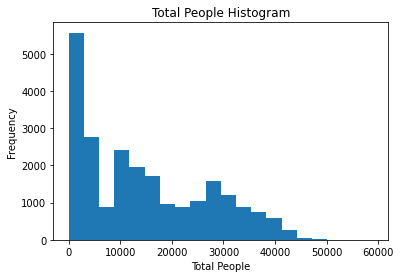

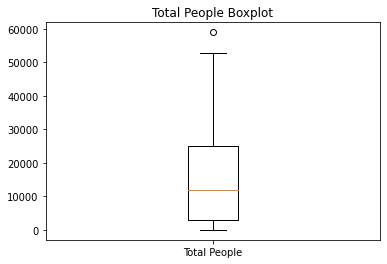

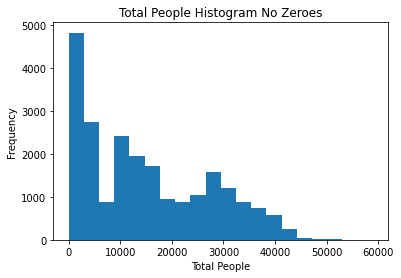

In [20]:
stats.print_stats_and_outliers(dfFootWeather["total_people"], "total_people", "Total People")

Do a K-Folds Cross Validation using XGBoost and get an MAE and an RMSE for mean error and indication of variance

In [21]:
# Test a basic XGBoost Regression with KFolds Cross Validation
randomSeed = databasic.get_random_seed()
# Tuned {'colsample_bytree': 0.7, 'eta': 0.01, 'max_depth': 10, 'n_estimators': 1000}
model = xgb.XGBRegressor(objective="reg:squarederror", booster="gbtree", 
     n_estimators=1000, max_depth=10, colsample_bytree=0.7, eta=0.1, seed=randomSeed)
modellingLog = ""   

targetColName = "total_people"
col_names = dfFootWeather.columns
feature_cols = col_names.drop([targetColName])
trainFeatures = dfFootWeather[feature_cols]
trainTargets = dfFootWeather[targetColName]


In [22]:

lstMae = []
lstRmse = []
lstR2 = []
lstExplainedVar = []
kfolds = KFold(n_splits=5, random_state=randomSeed, shuffle=True)
for k, (train_index, test_index) in enumerate(kfolds.split(dfFootWeather)):
    # x_train = trainFeatures.loc[train_index, ]
    # x_vali = trainFeatures.loc[test_index, ]

    # y_train = trainTargets.loc[train_index, ]
    # y_vali = trainTargets.loc[test_index, ]
    x_train = trainFeatures.loc[trainFeatures.index.intersection(train_index)]
    x_vali = trainFeatures.loc[trainFeatures.index.intersection(test_index)]
    
    y_train = trainTargets.loc[trainTargets.index.intersection(train_index)]
    y_vali = trainTargets.loc[trainTargets.index.intersection(test_index)]
        
    model.fit(x_train, y_train)
    y_pred = model.predict(x_vali)

    # Compute the mae
    mae = mean_absolute_error(y_pred=y_pred, y_true=y_vali)
    lstMae.append(mae)

    # Compute the rmse
    rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_vali))
    lstRmse.append(rmse)
    
    r2 = r2_score(y_pred=y_pred, y_true=y_vali)
    lstR2.append(r2)

    explainedVar = explained_variance_score(y_pred=y_pred, y_true=y_vali)
    lstExplainedVar.append(explainedVar)

    print("Fold {0} MAE: {1}, RMSE: {2}, R2: {3} Explained Variance {4}".format(str(k), str(mae), str(rmse), str(r2), str(explainedVar)))

    dfPredicted = x_vali
    dfPredicted["total_people"] = y_vali
    dfPredicted["total_people_predicted"] = y_pred
    dfPredicted.to_csv("./predictions/" + thisFileName+"_KFold" + str(k) + ".csv", index=False)

print("Final Result")
print("----------")
print("Average Mean Absolute Error (MAE): " + str(np.mean(lstMae)))
print("Average Root Mean Squared Error (RMSE): " + str(np.mean(lstRmse)))
print("Average R2 Score (R2): " + str(np.mean(lstR2)))
print("Average Explained Variance Score: " + str(np.mean(lstExplainedVar)))


print("maeResults.append(" + str(np.mean(lstMae)) + ")")
print("rmseResults.append(" + str(np.mean(lstRmse)) + ")")
print("r2Results.append(" + str(np.mean(lstR2)) + ")")
print("explainedVarResults.append(" + str(np.mean(lstExplainedVar)) + ")")


Fold 0 MAE: 1140.869891982947, RMSE: 2167.3755452172454, R2: 0.9677344307751479 Explained Variance 0.9677348106629334
Fold 1 MAE: 1112.1889990852812, RMSE: 2140.2751533413407, R2: 0.9696151862527369 Explained Variance 0.96961544101222
Fold 2 MAE: 1134.2253877018377, RMSE: 2078.0005977333076, R2: 0.9711516200222162 Explained Variance 0.9711523232781717
Fold 3 MAE: 1158.0202034583588, RMSE: 2210.5941724683753, R2: 0.9676342953730473 Explained Variance 0.9676347196175613
Fold 4 MAE: 1178.5742416001137, RMSE: 2179.615563170939, R2: 0.9673344739688255 Explained Variance 0.9673388600540057
Final Result
----------
Average Mean Absolute Error (MAE): 1144.7757447657077
Average Root Mean Squared Error (RMSE): 2155.1722063862417
Average R2 Score (R2): 0.9686940012783948
Average Explained Variance Score: 0.9686952309249784
maeResults.append(1144.7757447657077)
rmseResults.append(2155.1722063862417)
r2Results.append(0.9686940012783948)
explainedVarResults.append(0.9686952309249784)


# Version 3 - same as version 2 but tuned

Run 1:
- Average Mean Absolute Error (MAE): 1121.0414643434003
- Average Root Mean Squared Error (RMSE): 2129.5900508703976

Run 2:
- Average Mean Absolute Error (MAE): 1143.2207060840512
- Average Root Mean Squared Error (RMSE): 2135.8656044644054

Run 3:
- Average Mean Absolute Error (MAE): 1158.7994096470034
- Average Root Mean Squared Error (RMSE): 2170.9837754474524


# Version 2 - Added holidays, lockdown dates, retail data and all ords data

Run 1:
- Average Mean Absolute Error (MAE): 2427.7061911435057
- Average Root Mean Squared Error (RMSE): 3880.6926322712666

Run 2:
- Average Mean Absolute Error (MAE): 2430.2261640958413
- Average Root Mean Squared Error (RMSE): 3865.9539948526444

Run 3:
- Average Mean Absolute Error (MAE): 2428.957682123305
- Average Root Mean Squared Error (RMSE): 3876.7395727045455

# Version 1 - Just the basic weather data
This is before the following was added in: holidays, lockdown dates, retail data and all ords data

Run 1:
- Average Mean Absolute Error (MAE): 2920.0653982122726
- Average Root Mean Squared Error (RMSE): 4807.48902009495

Run 2:
- Average Mean Absolute Error (MAE): 2879.142585249733
- Average Root Mean Squared Error (RMSE): 4723.4315077591855

Run 3:
- Average Mean Absolute Error (MAE): 2898.2915500385693
- Average Root Mean Squared Error (RMSE): 4769.295103327263

Run 4:
- Average Mean Absolute Error (MAE): 2641.3858962528147
 -Average Root Mean Squared Error (RMSE): 4262.662939275366

In [23]:
avgTotalPeople = np.mean(dfFootWeather["total_people"])
maeResults = []
rmseResults = []
r2Results = []
explainedVarResults = []

maeResults.append(1144.7757447657077)
rmseResults.append(2155.1722063862417)
r2Results.append(0.9686940012783948)
explainedVarResults.append(0.9686952309249784)

avgMae = np.mean(maeResults)
avgRmse = np.mean(rmseResults)
avgR2 = np.mean(r2Results)
avgExplainedVar = np.mean(explainedVarResults)

predictionAccuracy = 100 - np.round((avgMae / avgTotalPeople) * 100, 2)
percentAvgAccuracyError = np.round((avgRmse / avgTotalPeople) * 100, 2)

print("Average for Total People per street location reading: " + str(avgTotalPeople) + "")
print("Averaged MAE: " + str(avgMae) + "")
print("Averaged RMSE: " + str(avgRmse) + "")
print("Averaged R2: " + str(avgR2) + "")
print("Averaged Explained Variance: " + str(avgExplainedVar) + "")

print("Predictions made to an accuracy of: " + str(predictionAccuracy) + "%")
print("Predictions Error: +/-" + str(percentAvgAccuracyError) + "%")

Average for Total People per street location reading: 14693.907893059039
Averaged MAE: 1136.135483532415
Averaged RMSE: 2126.916810132508
Averaged R2: 0.9694921627150681
Averaged Explained Variance: nan
Predictions made to an accuracy of: 92.27%
Predictions Error: +/-14.47%


c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
